In [3]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.combine import SMOTETomek

# ----------------------
# 1. Load & Preprocess Data
# ----------------------
file_location = "/content/GOUT-CC-2020-CORPUS-REDACTED.csv"
df = pd.read_csv(file_location)



# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Text preprocessing function
def preprocess_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)

# Apply preprocessing
df['Processed_Text'] = df['Chief Complaint'].apply(preprocess_text)

# ----------------------
# 2. Train-Test Split & TF-IDF Vectorization
# ----------------------
X_train, X_test, y_train, y_test = train_test_split(
    df['Processed_Text'], df['Predict'], test_size=0.2, random_state=42, stratify=df['Predict']
)

# Convert text labels ('N', 'U', 'Y') into binary format (Neutral vs. Non-Neutral)
y_train = y_train.apply(lambda x: 0 if x == "N" else 1)
y_test = y_test.apply(lambda x: 0 if x == "N" else 1)

# Apply TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Print dataset shape after vectorization
print("Train Data Shape:", X_train_tfidf.shape)
print("Test Data Shape:", X_test_tfidf.shape)

# checking the distribution of y_train and y_test
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

# ----------------------
# 3. Baseline Model Training (Without SMOTE & Class Balancing)
# ----------------------
print("\n===== Training Models (Baseline - No Improvements) =====")

baseline_models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": MultinomialNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

baseline_results = {}

for name, model in baseline_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    baseline_results[name] = {
        "Accuracy": accuracy,
        "Precision (Class 1)": report["1"]["precision"],
        "Recall (Class 1)": report["1"]["recall"],
        "F1-score (Class 1)": report["1"]["f1-score"]
    }

    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

# ----------------------
# 4. Apply SMOTE + Tomek Links for Class Balancing
# ----------------------
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train_tfidf, y_train)

# Check new class distribution
print("\nClass distribution after SMOTE + Tomek Links:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

# ----------------------
# 5. Train Improved Models (With SMOTE, Class Weighting & Threshold Tuning)
# ----------------------
print("\n===== Training Models (With Improvements) =====")

improved_models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced"),
    "SVM": SVC(probability=True, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(class_weight="balanced_subsample"),
    "Naive Bayes": MultinomialNB(),
    "XGBoost": XGBClassifier(scale_pos_weight=50, eval_metric="logloss")
}

improved_results = {}

for name, model in improved_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_resampled, y_train_resampled)

    # Predict probabilities for threshold tuning
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]
        y_pred = (y_pred_proba >= 0.3).astype(int)  # Lower threshold
    else:
        y_pred = model.predict(X_test_tfidf)  # Fallback for SVM (no predict_proba)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    improved_results[name] = {
        "Accuracy": accuracy,
        "Precision (Class 1)": report["1"]["precision"],
        "Recall (Class 1)": report["1"]["recall"],
        "F1-score (Class 1)": report["1"]["f1-score"]
    }

    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

# ----------------------
# 6. Compare Baseline vs. Improved Models
# ----------------------
comparison_df = pd.DataFrame.from_dict(baseline_results, orient="index")
comparison_df = comparison_df.rename(columns=lambda x: "Baseline " + x)

improved_df = pd.DataFrame.from_dict(improved_results, orient="index")
improved_df = improved_df.rename(columns=lambda x: "Improved " + x)

final_comparison = pd.concat([comparison_df, improved_df], axis=1)
print("\n===== Model Comparison (Before vs. After Improvements) =====")
print(final_comparison)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Train Data Shape: (6509, 5000)
Test Data Shape: (1628, 5000)
Predict
0    0.982179
1    0.017821
Name: proportion, dtype: float64
Predict
0    0.982187
1    0.017813
Name: proportion, dtype: float64

===== Training Models (Baseline - No Improvements) =====

Training Logistic Regression...
Logistic Regression Accuracy: 0.9816
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1599
           1       0.00      0.00      0.00        29

    accuracy                           0.98      1628
   macro avg       0.49      0.50      0.50      1628
weighted avg       0.96      0.98      0.97      1628


Training SVM...
SVM Accuracy: 0.9828
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1599
           1       1.00      0.03      0.07        29

    accuracy                           0.98      1628
   macro avg       0.99      0.52      0.53      1628
weighted avg       0.98      0.98   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Random Forest Accuracy: 0.9822
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1599
           1       0.00      0.00      0.00        29

    accuracy                           0.98      1628
   macro avg       0.49      0.50      0.50      1628
weighted avg       0.96      0.98      0.97      1628


Training Naive Bayes...
Naive Bayes Accuracy: 0.9822
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1599
           1       0.00      0.00      0.00        29

    accuracy                           0.98      1628
   macro avg       0.49      0.50      0.50      1628
weighted avg       0.96      0.98      0.97      1628


Training XGBoost...
XGBoost Accuracy: 0.9828
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1599
           1       0.57      0.14      0.22        29

    accuracy                           0.98      16

In [4]:
import pandas as pd

# Create DataFrame from improved model results
comparison_df = pd.DataFrame.from_dict(improved_results, orient="index")

# Rename columns for clarity
comparison_df = comparison_df.rename(columns={
    "Accuracy": "Accuracy",
    "Precision (Class 1)": "Precision",
    "Recall (Class 1)": "Recall",
    "F1-score (Class 1)": "F1 Score"
})

# Print the table
print("\n===== Model Comparison Table =====")
print(comparison_df)

# Save table as CSV (optional)
comparison_df.to_csv("model_comparison.csv", index=True)



===== Model Comparison Table =====
                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.949631   0.242718  0.862069  0.378788
SVM                  0.982187   0.500000  0.034483  0.064516
Random Forest        0.978501   0.392857  0.379310  0.385965
Naive Bayes          0.894349   0.121693  0.793103  0.211009
XGBoost              0.966216   0.296875  0.655172  0.408602


<Figure size 1000x600 with 0 Axes>

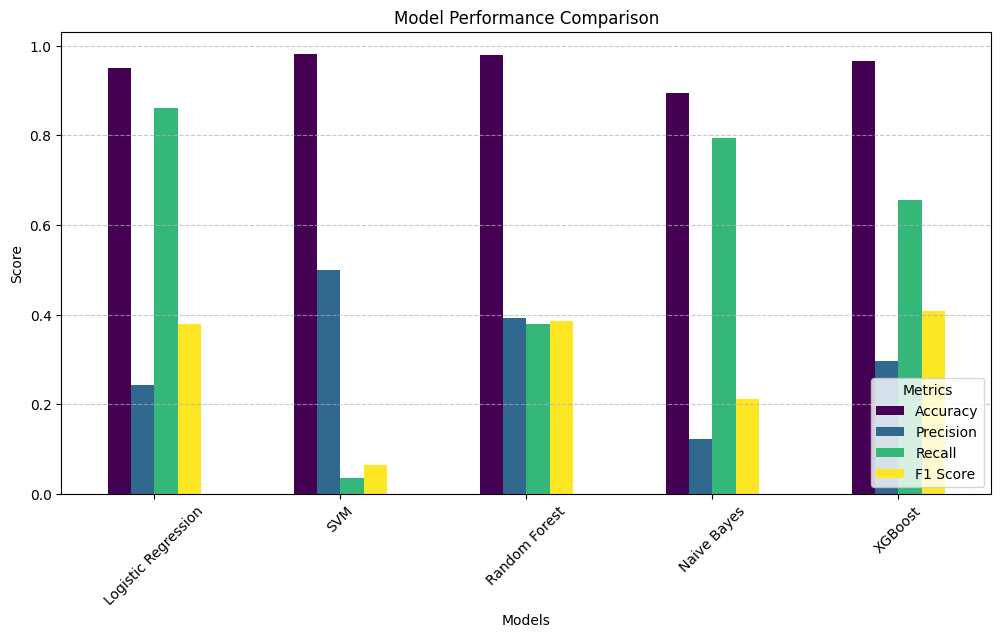

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Comparison Graph
plt.figure(figsize=(10, 6))
comparison_df.plot(kind="bar", figsize=(12, 6), colormap="viridis")

plt.title("Model Performance Comparison")
plt.xlabel("Models")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metrics", loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

<ipython-input-6-fa59f089a631>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="F1 Score", y="Model", data=f1_df, palette="coolwarm")


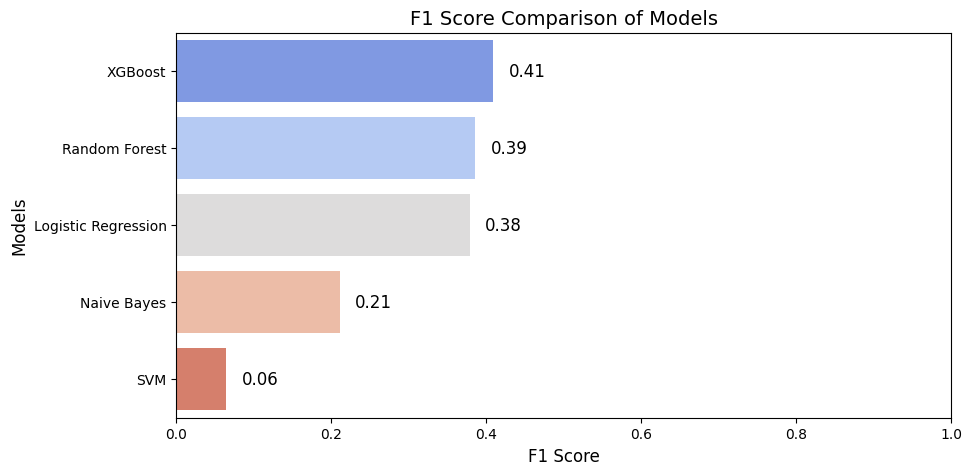

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract F1 scores for each model
f1_scores = {model: metrics["F1-score (Class 1)"] for model, metrics in improved_results.items()}

# Convert to DataFrame
f1_df = pd.DataFrame(list(f1_scores.items()), columns=["Model", "F1 Score"])

# Sort values for better visualization
f1_df = f1_df.sort_values(by="F1 Score", ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="F1 Score", y="Model", data=f1_df, palette="coolwarm")

# Titles and labels
plt.title("F1 Score Comparison of Models", fontsize=14)
plt.xlabel("F1 Score", fontsize=12)
plt.ylabel("Models", fontsize=12)
plt.xlim(0, 1)  # Since F1-score ranges from 0 to 1

# Show values on bars
for index, value in enumerate(f1_df["F1 Score"]):
    plt.text(value + 0.02, index, f"{value:.2f}", va="center", fontsize=12)

plt.show()


<ipython-input-7-252d28013f96>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Accuracy", y="Model", data=accuracy_df, palette="viridis")


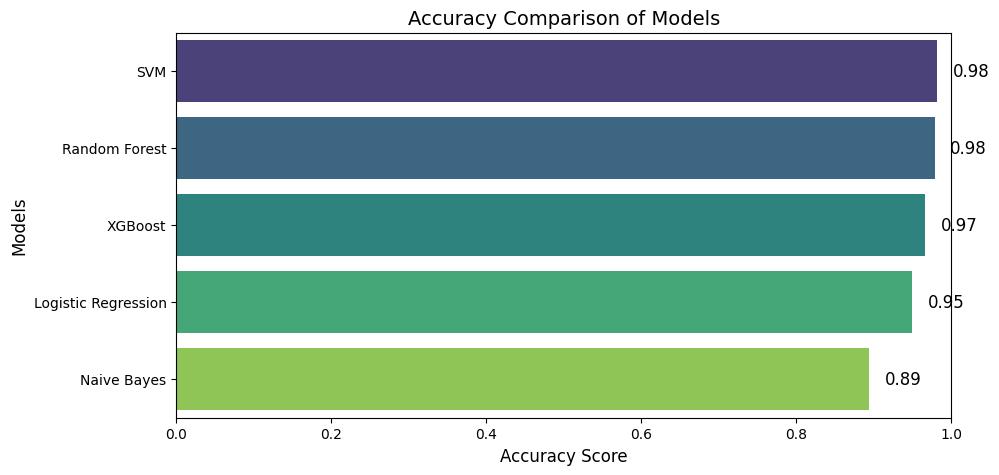

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract Accuracy scores for each model
accuracy_scores = {model: metrics["Accuracy"] for model, metrics in improved_results.items()}

# Convert to DataFrame
accuracy_df = pd.DataFrame(list(accuracy_scores.items()), columns=["Model", "Accuracy"])

# Sort values for better visualization
accuracy_df = accuracy_df.sort_values(by="Accuracy", ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="Accuracy", y="Model", data=accuracy_df, palette="viridis")

# Titles and labels
plt.title("Accuracy Comparison of Models", fontsize=14)
plt.xlabel("Accuracy Score", fontsize=12)
plt.ylabel("Models", fontsize=12)
plt.xlim(0, 1)  # Since accuracy ranges from 0 to 1

# Show values on bars
for index, value in enumerate(accuracy_df["Accuracy"]):
    plt.text(value + 0.02, index, f"{value:.2f}", va="center", fontsize=12)

plt.show()
